# Section 3: Jupyter Notebook

In this section, you will be running code blocks to train machine learning models. Each code block has some explanatory context above it, which you can refer back to if need be. 

Otherwise, we will explain each of the code blocks out loud, so you don't need to read all of the text.

## Part A: Import Necessary Libraries

Let's start by importing our libraries!

In [1]:
import pandas as pd # great for storing data in tables
import numpy as np # great at doing math on matrices of numbers
import matplotlib.pyplot as plt # great at plotting things

In [2]:
# load iris module
import iris
import warnings

warnings.simplefilter("ignore")

You'll also see this variable appear around the notebook. For the exercises, please backspace this variable and insert the correct answer.

In [3]:
__ANSWER_HERE__ = None # think of this as a "fill in the blank".

## Part B: Analyze our Data

### Preview the data

Before we begin, let's glance back over the data one more time. It's good to understand the columns we're working with when building our models, and from our work in Sections 1 and 2 of class, our data has shifted somewhat from its original state.

We'll start by reading in the data from our table into a new Pandas DataFrame, hereafter called `stroke_df`.

Running `.head()` on a Pandas DataFrame displays the first 5 rows, including all columns and their respective values. It's a good way to view the DataFrame at a glance.

**Exercise:** after the line defining the DataFrame `stroke_df`, run `.head()` on the DataFrame.


In [4]:
# connect to iris 

# change these variables to reflect your connection
hostname = "iris"
port = 1972
namespace = "APPL"
username = "SuperUser"
password = "SYS"

# connect
connection = iris.connect("{:}:{:}/{:}".format(hostname, port, namespace), username, password)

In [5]:
sql = "SELECT * FROM SQLUser.stroke_data_processed"
stroke_df = pd.read_sql_query(sql, connection, dtype = None)
stroke_df.head() # fill in the answer here.

,iris_id,id,gender,date_birth,age,hypertension,heart_disease,ever_married,work_type,zip,Residence_type,avg_glucose_level,height_in,weight_lb,bmi,smoking_status,stroke
0,1,77,Female,4/5/2007,13,0,0,No,children,98671,Rural,85.81,60.2,95.88,18.6,Unknown,0
1,2,84,Male,5/17/1965,55,0,0,Yes,Private,99126,Urban,89.17,72.8,237.48,31.5,never smoked,0
2,3,91,Female,3/29/1978,42,0,0,No,Private,98382,Urban,98.53,66.9,117.78,18.5,never smoked,0
3,4,99,Female,12/24/1989,31,0,0,No,Private,98323,Urban,108.89,55.5,229.16,52.3,Unknown,0
4,5,129,Female,8/23/1996,24,0,0,No,Private,98465,Urban,97.55,61.8,142.34,26.2,never smoked,0


## Part C: Prepare our Data

### Assigning `X` and `y` for our models

We can think of the output (`y`) as a function of the input (`X`). In other words, whether or not we think a given patient will have a stroke (`y`) based on an assortment of inputs, like their BMI, age and average glucose level (`X`). Here, we break up the `stroke_df` into two subsets `X` and `y`.

The _x_ and _y_ symbols are constantly used in math for this same purpose.

In [6]:
X = stroke_df[[ # new subset of each patient's attributes that might contribute to their stroke likelihood
    'gender', 
    'age',
    'ever_married',
    'hypertension', 
    'heart_disease', 
    'work_type', 
    'Residence_type',
    'avg_glucose_level', 
    'bmi',
    'smoking_status'
]]
y = stroke_df['stroke'] # whether or not each patient had a stroke

### Splitting our data for training and testing

We leave some of our data to *train* the model, and the rest to *test* the model's training.

**Exercise**: set the training data be 80% of the original DataFrame (`0.8`), and the `random_state` set to 42.

In [7]:
from sklearn.model_selection import train_test_split # a quick way to randomly split our data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

We can run `.head()` again on the `X_test` dataframe to see some of the patients that were included in the testing data.

In [8]:
X_test.head() # let's see who was included in the testing data!

,gender,age,ever_married,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4153,Male,34,Yes,0,0,Private,Urban,61.11,29.3,never smoked
3543,Female,25,No,0,0,Private,Rural,67.73,22.6,never smoked
907,Male,43,Yes,0,0,Govt_job,Rural,88.00,30.6,never smoked
2522,Female,65,No,0,0,Self-employed,Rural,86.33,33.1,never smoked
3107,Female,0,No,0,0,children,Urban,139.67,14.1,Unknown


## Part D: Running our Models

### XGBoost at a glance

To begin training a model, let's first initialize a classifier model from [the `xgboost` library](https://xgboost.ai/). Classification models are used to *classify* data into different categories, whereas *regression* models are used to predict numerical values. In our case, we're attempting to classify two states: stroke or non-stroke.

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*_Tybk5hymsWuYNDxJ0ZPdg.png" width="80%">

_[via Aviv Nahon on Medium.](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc)_

XGBoost uses [**gradient boosted decision trees**](https://towardsdatascience.com/a-visual-guide-to-gradient-boosted-trees-8d9ed578b33) to classify data. 

A **decision tree** has different "forks in the road" to send points down the path to classification. For example, a "fork" might ask: _"Does this patient have a high BMI?"_ If the answer is yes, the model may send that patient down the path towards positive stroke classification. These trees have a maximum number of **layers** the points can traverse down, and multiple trees can be created and compared to one another at once.

**Gradient boosting** combines weak learners, like "stumps" (trees with only one decision split), so that each new tree corrects the errors of its predecessor. XGBoost employs this method, as do similar libraries like CatBoost and LightGBM.

Run the block below to import `xgboost` and its classifier, `XGBClassifier`.

In [9]:
from xgboost import XGBClassifier

We'll also need to mark some of the columns as `categorical`, so that our `XGBClassifier` is ready to analyze them as such.

In [10]:
categorical_features = X_train.select_dtypes(include='object').columns
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

### Initializing the model

For our first model, let's choose some pretty basic hyperparameters:

| argument        | starting value | explanation                                                                                                                                                           |
|-----------------|----------------|----------------------------------------------------------------------------|
| `n_estimators`  | `2`            | The maximum number of trees that can be built during training.                                                                                                        |
| `max_depth`     | `3`            | The maximum depth of the tree.                                                                                                                                        |
| `learning_rate` | `0.01`         | How fast the model steps down the gradient. We don't want this to be too high or too low. |

The last few hyperparameters are filled in for you. `verbosity` is the level of reporting the model returns on a scale of 0-3, the `random_seed` ensures everyone's model performs the same, and `enable_categorical` allows XGBoost to take in categorical data (`"Female"`, `"Male"`, `"Other"` as opposed to `1`, `2` or `3`).

**Exercise:** fill in the missing values for our XGBClassifier.

In [11]:
model = XGBClassifier(
    n_estimators=2,            # the maximum number of trees to be created during training
    max_depth=3,               # the maximum depth of the tree
    learning_rate=0.01,           # how fast the model steps down the loss gradient
    verbosity=1,
    random_state=42,
    enable_categorical=True,
    tree_method="hist"
)

Now that our model has been instantiated, we can train it using the data we split earlier. If this were a sports movie, this would be the training montage.

In [12]:
model.fit(X_train, y_train) # train our model using our splitted data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=2, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

The model has now read read through all patients belonging to the training data and is ready to make its own assessments for unseen patients. To put our model to the test, we feed it patients it's never seen before. If this were a sports movie, this would be the big game.

In [13]:
preds_proba = model.predict_proba(X_test)

This seems like a good accuracy, but let's check out the AUC. The `sklearn` library gives us access to a method, `metrics.roc_auc_score()`, that allows us to calculate this easily. Let's try this function on the model we just trained.

**Exercise:** call `metrics.roc_auc_score()`, using `y_test` and `preds_proba[:,1]` as the respective arguments. `[:,1]` at the end of `preds_proba` creates a new view of the array, including nothing but the positive scores.

In [14]:
from sklearn import metrics
metrics.roc_auc_score(y_test, preds_proba[:,1]) # let's check out the AUC of our first model.

0.842966745289132

An AUC of ~0.84 is pretty good! However, IRIS Integrated ML performed better at 0.87. Perhaps if we tried some fancier hyperparameters, we could beat that score. 

Our model is still pretty basic. To demonstrate this, let's see the spread of positive weights it gave to the patients in the testing data.

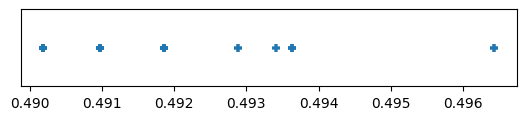

In [15]:
weights = np.array(preds_proba[:,1]) # an array of the positive categorization scores the model assigned to each patient
n = len(weights)
X = weights
Y = np.zeros(n)

fg = plt.figure()
fg.set_figheight(1)
plt.scatter(X, Y, marker="+")
plt.xticks()
plt.yticks(())

plt.show() # plot the graph

There's barely any diversity in the risk scores it's giving to each patient. The smallest positive score sits at ~0.4902, and the highest sits at ~0.496. It's not terribly opinionated on what determines a higher likelihood for a stroke, which means we need to tune it more closely.

## Part E: Coding a smarter model

Our model could use some better hyperparameters. To create a smarter model, let's tune some of our preexisting hyperparameters, and add a few more.

**You don't need to understand each hyperparameter,** but you can visit [this link](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) on your own to learn more about `XGBClassifier`'s hyperparameters.

These (incredibly) specific values for each hyperparameter were generated automatically during a process called [automated hyperparameter tuning](https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d).

In [16]:
params = {
    'n_estimators': 30,                      # the maximum number of trees to be created during training
    'max_depth': 5,                          # the maximum depth of each tree
    'learning_rate': 0.26634027963287155,    # how fast the model steps down the loss gradient
    'subsample': 0.7085736032465515,
    'min_child_weight': 14,
    'gamma': 1.5174644767193246, 
    'scale_pos_weight': 2, 
    'reg_lambda': 0.7417953276343711, 
    'reg_alpha': 0.5572815198039048, 
    'colsample_bytree': 0.8805086604399132
}

fancier_model = XGBClassifier(
    enable_categorical=True,
    tree_method="hist",
    random_state=20230413,
    **params
)

Again, let's go through the steps of training and testing our model. This might take a little bit to train.

In [17]:
fancier_model.fit(X_train, y_train)
fancier_preds_class = fancier_model.predict(X_test)
fancier_preds_proba = fancier_model.predict_proba(X_test)

### Understanding the AUC

To start, let's see what percentage of our testing data actually had a stroke. We'll need this to understand the next few cells.

In [18]:
test_df = X_test.copy()
test_df['stroke'] = y_test
test_df['probability'] = fancier_preds_proba[:,1]
total_stroke = len(test_df.query('stroke == 1'))

print(f"{total_stroke} patients out of {len(test_df)} patients in the test data actually had a stroke.")

41 patients out of 982 patients in the test data actually had a stroke.


Before we compute the AUC of our model, let's see which patients were ranked highest in terms of stroke risk. We'll display the first 41 patients -- with a model with a perfect AUC, the first 41 patients would _all_ be positive cases.

From the output of the below cell, pay attention to the last two columns. `stroke` shows whether or not this patient _actually_ had a stroke, and `probability` shows the risk score our model assigned to the patient.

In [19]:
test_df = X_test.copy()
test_df['stroke'] = y_test
test_df['probability'] = fancier_preds_proba[:,1]
test_df.sort_values('probability', ascending=False, ignore_index=True, inplace=True)
test_df.head(total_stroke) # let's see the first 41 rows. how many are actual stroke patients?

,gender,age,ever_married,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,probability
0,Male,81,Yes,1,1,Private,Urban,250.89,28.1,smokes,1,0.694814
1,Female,80,Yes,1,0,Private,Urban,89.16,24.0,never smoked,0,0.656811
2,Female,82,Yes,1,0,Private,Urban,62.46,20.3,formerly smoked,0,0.617421
3,Male,80,Yes,1,0,Private,Urban,240.09,27.0,never smoked,1,0.599910
4,Male,80,Yes,1,1,Private,Urban,175.29,31.5,formerly smoked,1,0.568616
5,Female,82,No,0,1,Private,Urban,215.60,24.9,never smoked,0,0.554714
6,Male,82,Yes,1,0,Private,Rural,227.28,33.3,never smoked,0,0.529555
7,Female,81,Yes,1,1,Private,Rural,126.34,27.4,smokes,0,0.504500
8,Female,78,Yes,0,1,Private,Rural,221.06,25.5,formerly smoked,0,0.504305
9,Female,81,Yes,0,0,Private,Urban,82.86,25.0,never smoked,0,0.500907


At first glance, this doesn't seem like a very good output. There are a few 1's in there, but there are mostly 0's.

However, if we eyeball the output of the next cell, we can notice that most of the positive cases are _above_ the halfway point (982 / 2 = 491) in the sorted testing data.

In [20]:
test_df.query('stroke == 1') # where are the real stroke patients? (look at the index column)

,gender,age,ever_married,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,probability
0,Male,81,Yes,1,1,Private,Urban,250.89,28.1,smokes,1,0.694814
3,Male,80,Yes,1,0,Private,Urban,240.09,27.0,never smoked,1,0.599910
4,Male,80,Yes,1,1,Private,Urban,175.29,31.5,formerly smoked,1,0.568616
10,Female,82,Yes,1,0,Self-employed,Urban,196.92,22.2,never smoked,1,0.497264
12,Male,82,Yes,0,1,Private,Urban,144.90,26.4,smokes,1,0.478408
16,Female,79,Yes,0,0,Private,Urban,110.85,24.1,formerly smoked,1,0.451471
25,Male,64,Yes,0,1,Private,Urban,191.61,37.5,smokes,1,0.398223
27,Female,77,Yes,0,0,Govt_job,Rural,190.32,31.4,never smoked,1,0.375214
29,Female,78,No,1,0,Private,Urban,130.54,20.1,never smoked,1,0.370063
31,Male,82,Yes,0,0,Govt_job,Urban,200.59,29.0,formerly smoked,1,0.363671


After eyeballing the positive cases, let's calculate the AUC for our `fancier_model`.

**Exercise:** call `metrics.roc_auc_score()` using `y_test` and `fancier_preds_proba[:,1]` as arguments.

In [21]:
metrics.roc_auc_score(y_test, fancier_preds_proba[:,1]) # compute the AUC for our fancier model

0.8905678961146678

This means that, 89% of the time, a randomly selected stroke class will have a higher positive probability using the ML model than a randomly selected non-stroke class. This is a pretty good AUC score!

To see the bigger picture, let's check out the spread of positive scores the model assigned to patients in the testing data.

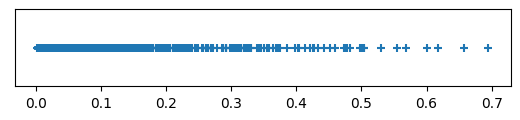

In [22]:
weights = np.array(fancier_preds_proba[:,1]) # an array of the positive categorization scores the fancier_model assigned to each patient
n = len(weights)
X = weights
Y = np.zeros(n)

fg = plt.figure()
fg.set_figheight(1)
plt.scatter(X, Y, marker="+")
plt.xticks()
plt.yticks(())

plt.show() # plot the graph

As we can see, there is a wide spread of weights between ~0.01 and ~0.70 -- a much nicer spread than our previous model. Our model is much more opinionated!

## Part F (Bonus): Feature Importance

Let's see which columns caused the greatest impact on our model's risk scores.

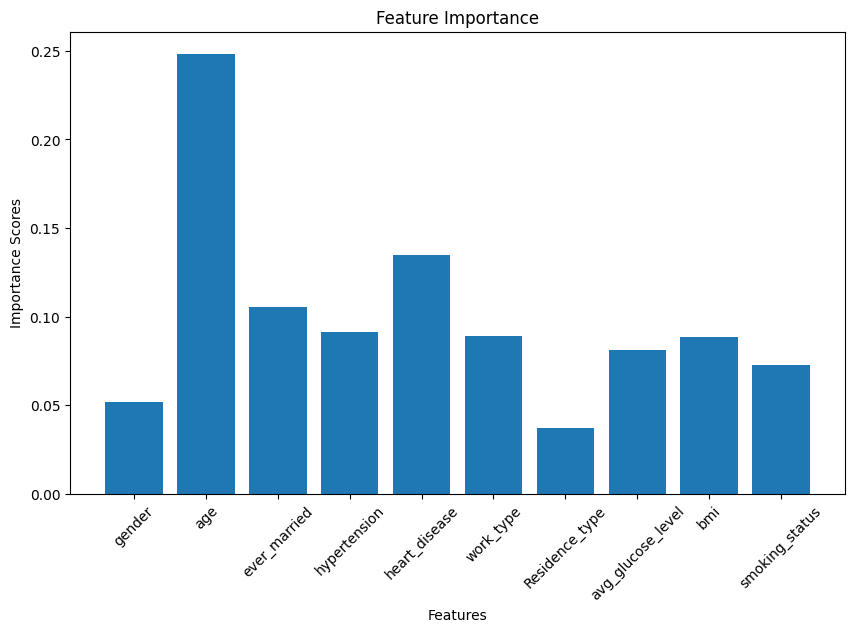

In [23]:
importance_scores = fancier_model.feature_importances_

# create a bar chart of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance_scores)), importance_scores)
plt.xticks(range(len(importance_scores)), X_train.columns)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.xticks(rotation=45)
plt.show()

## Part G: Exporting the Model

All we need to do now is export the model to our machine so that we can load it into the next section, where we will explore ObjectScript Embedded Python!

In [24]:
fancier_model.save_model("/tmp/xgboost_export.json") # save the model for the next section